# Corn Diseases Detection - Hybrid Model(VGG-19 and ResNext)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model
import random
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Load pre-trained models

In [135]:
vgg19_model = load_model('../VGG-19/vgg19_model.keras')
resnext_model = load_model('../ResNext/resnext_model.keras')

# Load their training histories

In [136]:
vgg19_history = np.load('../VGG-19/vgg19_history.npy', allow_pickle=True).item()
resnext_history = np.load('../ResNext/resnext_history.npy', allow_pickle=True).item()

# Dataset Path

In [138]:
train_dir = "../../Corn Dataset/train"
test_dir = "../../Corn Dataset/test"

# Data Augmentation and Preprocessing

In [139]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5940 images belonging to 6 classes.
Found 660 images belonging to 6 classes.


# Get predictions from both models

In [140]:
vgg19_predictions = vgg19_model.predict(test_data)
resnext_predictions = resnext_model.predict(test_data)

21/21 ━━━━━━━━━━━━━━━━━━━━ 118s 6s/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step


# Average the predictions

In [141]:
combined_predictions = (vgg19_predictions + resnext_predictions) / 2

# Hybrid Model predictions

In [142]:
hybrid_predictions = np.argmax(combined_predictions, axis=1)

# Plotting confusion matrix

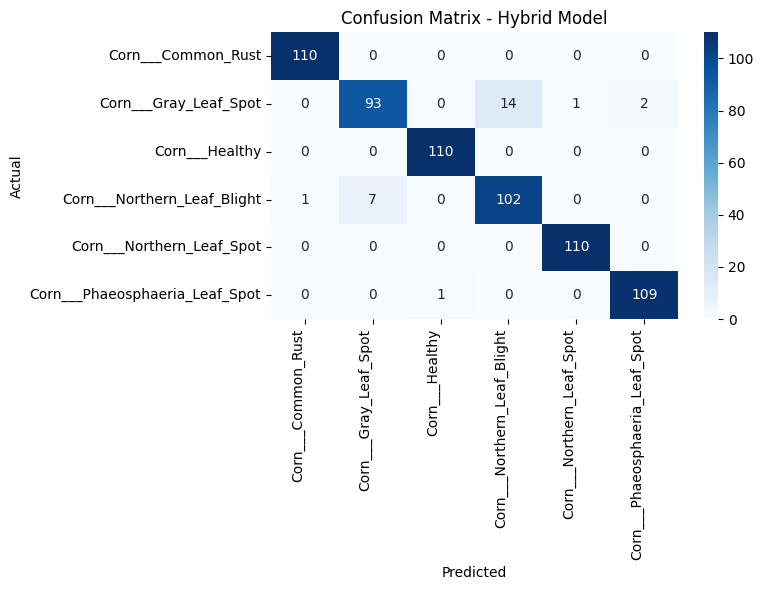

In [145]:
conf_matrix = confusion_matrix(test_data.classes, hybrid_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid Model")
plt.xticks(rotation=90, ha='right')
plt.tight_layout()  
plt.savefig("hybrid_model_confusion_matrix.png", dpi=300)
plt.show()

# Evaluate Hybrid Model

In [151]:
vgg19_model_test_loss, vgg19_model_test_accuracy = vgg19_model.evaluate(test_data, verbose=1)
resnext_model_test_loss, resnext_model_test_accuracy = resnext_model.evaluate(test_data, verbose=1)

hybrid_model_accuracy = (vgg19_model_test_accuracy + resnext_model_test_accuracy) / 2 * 100
print(f"Test Accuracy Hybrid Model: {hybrid_model_accuracy:.2f}%")

21/21 ━━━━━━━━━━━━━━━━━━━━ 118s 6s/step - accuracy: 0.9413 - loss: 0.1576
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.9528 - loss: 0.1369
Test Accuracy Hybrid Model: 94.70%


# Classification report

In [154]:
report = classification_report(test_data.classes, hybrid_predictions, target_names=list(test_data.class_indices.keys()))
print(report)

                                precision    recall  f1-score   support

            Corn___Common_Rust       0.99      1.00      1.00       110
         Corn___Gray_Leaf_Spot       0.93      0.85      0.89       110
                Corn___Healthy       0.99      1.00      1.00       110
   Corn___Northern_Leaf_Blight       0.88      0.93      0.90       110
     Corn___Northern_Leaf_Spot       0.99      1.00      1.00       110
Corn___Phaeosphaeria_Leaf_Spot       0.98      0.99      0.99       110

                      accuracy                           0.96       660
                     macro avg       0.96      0.96      0.96       660
                  weighted avg       0.96      0.96      0.96       660



# Model predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


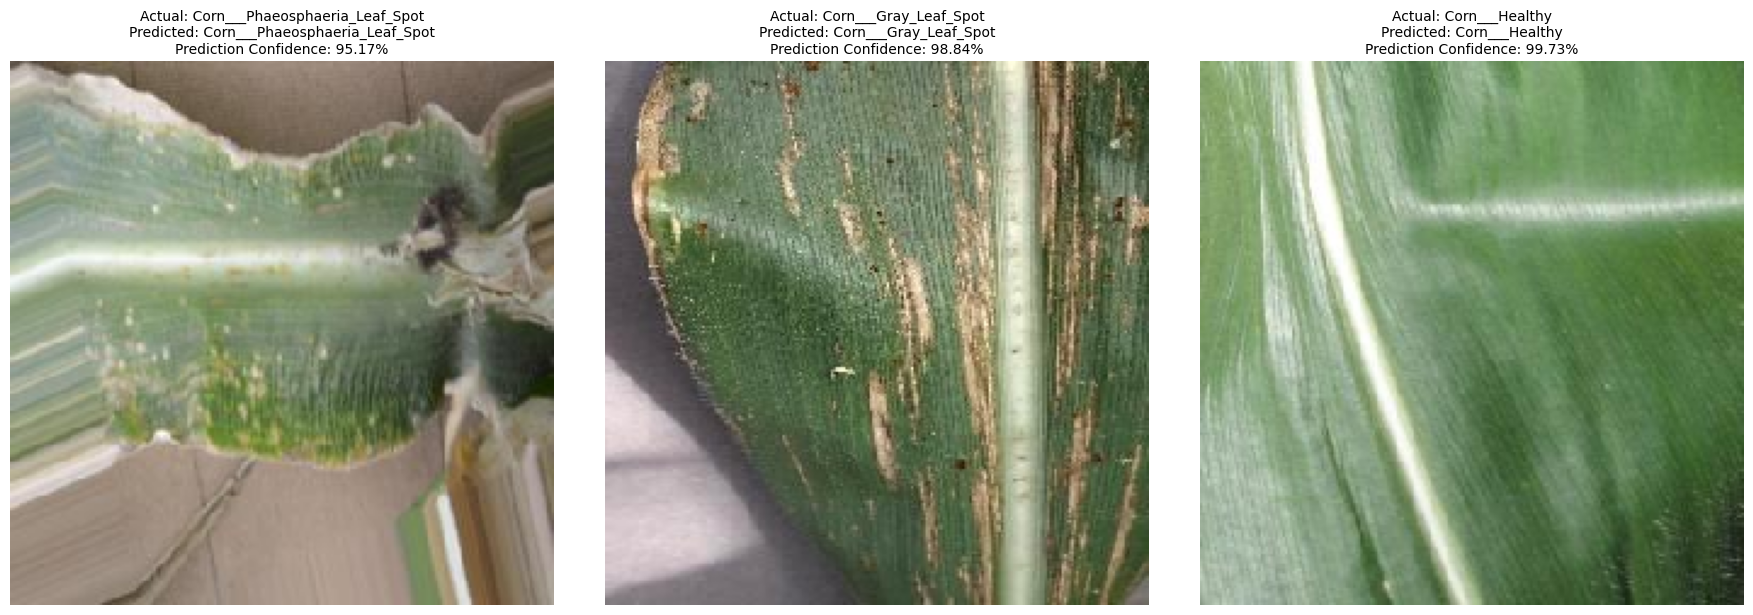

In [167]:
def predict_random_images(vgg19_model, resnext_model, test_dir, class_indices):
    """
    Predict three random images from the test dataset using VGG-19 and ResNeXT models, then take the average of their predictions.
    """
   
    class_labels = {v: k for k, v in class_indices.items()}

    
    selected_classes = random.sample(os.listdir(test_dir), 3)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 

    for ax, class_name in zip(axes, selected_classes):
        class_dir = os.path.join(test_dir, class_name)
        image_files = os.listdir(class_dir)

      
        img_name = random.choice(image_files)
        img_path = os.path.join(class_dir, img_name)

     
        img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

      
        vgg19_prediction = vgg19_model.predict(img_array)
        resnext_prediction = resnext_model.predict(img_array)

     
        combined_prediction = (vgg19_prediction + resnext_prediction) / 2
        predicted_class = class_labels[np.argmax(combined_prediction)]
        confidence = np.max(combined_prediction) * 100

       
        ax.imshow(img)
        ax.set_title(f"Actual: {class_name}\nPredicted: {predicted_class}\nPrediction Confidence: {confidence:.2f}%", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.savefig("predictions_hybrid.png", bbox_inches="tight")
    plt.show()


predict_random_images(vgg19_model, resnext_model, test_dir, test_data.class_indices)


# Plot accuracy and loss graphs

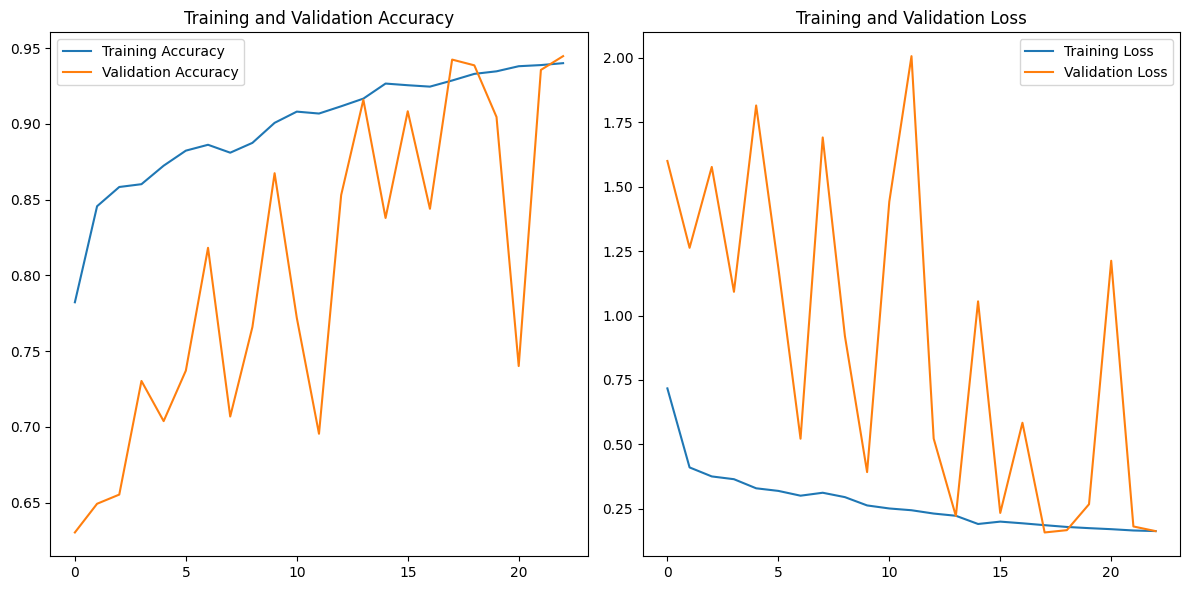

In [174]:
vgg19_history = np.load('../VGG-19/vgg19_history.npy', allow_pickle=True).item()
resnext_history = np.load('../ResNext/resnext_history.npy', allow_pickle=True).item()

min_length = min(len(vgg19_history['accuracy']), len(resnext_history['accuracy']))
vgg19_history = {k: v[:min_length] for k, v in vgg19_history.items()}
resnext_history = {k: v[:min_length] for k, v in resnext_history.items()}

def plot_training_history(vgg19_history, resnext_history):
    epochs = range(min_length)

    vgg19_acc = vgg19_history['accuracy']
    vgg19_val_acc = vgg19_history['val_accuracy']
    vgg19_loss = vgg19_history['loss']
    vgg19_val_loss = vgg19_history['val_loss']

    resnext_acc = resnext_history['accuracy']
    resnext_val_acc = resnext_history['val_accuracy']
    resnext_loss = resnext_history['loss']
    resnext_val_loss = resnext_history['val_loss']

    
    combined_acc = (np.array(vgg19_acc) + np.array(resnext_acc)) / 2
    combined_val_acc = (np.array(vgg19_val_acc) + np.array(resnext_val_acc)) / 2
    combined_loss = (np.array(vgg19_loss) + np.array(resnext_loss)) / 2
    combined_val_loss = (np.array(vgg19_val_loss) + np.array(resnext_val_loss)) / 2

   
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, combined_acc, label='Training Accuracy')
    plt.plot(epochs, combined_val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, combined_loss, label='Training Loss')
    plt.plot(epochs, combined_val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.savefig("Combined_Accuracy&Loss_Graphs.png", dpi=300)
    plt.show()

plot_training_history(vgg19_history, resnext_history)